In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from scipy.stats import kendalltau

In [38]:
FICHEIRO_COMITE_LLM = '../../data/judged/committee_llm_consensus.csv' 
FICHEIRO_GROUND_TRUTH_HUMANO = '../../data/judged/human_ground_truth.csv'
FICHEIRO_MASTER = '../../data/processed/sample_master.csv'

In [39]:
df_llm = pd.read_csv(FICHEIRO_COMITE_LLM)
df_llm.head(2)

,evaluation_id,response_A,response_B,evaluation_claude,evaluation_prometheus,evaluation_mistral,claude_winner,claude_total_score,mistral_winner,mistral_total_score,prometheus_winner,prometheus_total_score,gold_winner
0,TC014_gemini-1.5-pro-latest_1_Technical_contex...,The primary use of a NumPy array is to efficie...,Numple matrices are the central data structure...,"{\n ""winner"": ""A"",\n ""general_justificat...","{\n ""winner"": ""A"",\n ""general_ju...","{\n ""winner"": ""A"",\n ""general_j...",A,5.0,A,5.00,A,5.00,A
1,CG004_gemini-1.5-pro-latest_4_General Knowledg...,The Proclamation of the Republic in Brazil on ...,"The proclamation of the Republic in Brazil, on...","{\n ""winner"": ""A"",\n ""general_justificat...","{\n""winner"": ""Tie"",\n""general_justification"": ...","{\n ""winner"": ""A"",\n ""general_justification...",A,5.0,A,4.75,Tie,4.75,A


In [40]:
df_human = pd.read_csv(FICHEIRO_GROUND_TRUTH_HUMANO)
df_human.head(2)

,evaluation_id,human_winner
0,CG001_sabia-3.1_2_General Knowledge_detailed_e...,Tie
1,CG002_1_General Knowledge_minimum_gemini-1.5-p...,B


In [41]:
df_analise = pd.merge(df_llm, df_human, on='evaluation_id', how='left')
print("\nFicheiros juntados com sucesso.")
df_analise.shape


Ficheiros juntados com sucesso.


(1500, 14)

In [42]:
def extrair_metadados(evaluation_id):
    if not isinstance(evaluation_id, str):
        return None, None
    
    # Extrair Domínio
    domains = ['Technical', 'General Knowledge', 'Creative']
    domain = next((d for d in domains if d in evaluation_id), 'Desconhecido')
    
    # Extrair Língua
    if evaluation_id.endswith('_en_vs_pt'):
        lang = 'EN vs PT'
    elif evaluation_id.endswith('_en'):
        lang = 'EN'
    elif evaluation_id.endswith('_pt'):
        lang = 'PT'
    else:
        lang = 'Desconhecido'
        
    return domain, lang

In [43]:
df_analise[['domain', 'language_context']] = df_analise['evaluation_id'].apply(lambda eid: pd.Series(extrair_metadados(eid)))
print("Metadados (domínio e língua) extraídos com sucesso.")
df_analise.shape

Metadados (domínio e língua) extraídos com sucesso.


(1500, 16)

In [44]:
df_analise.head(2)

,evaluation_id,response_A,response_B,evaluation_claude,evaluation_prometheus,evaluation_mistral,claude_winner,claude_total_score,mistral_winner,mistral_total_score,prometheus_winner,prometheus_total_score,gold_winner,human_winner,domain,language_context
0,TC014_gemini-1.5-pro-latest_1_Technical_contex...,The primary use of a NumPy array is to efficie...,Numple matrices are the central data structure...,"{\n ""winner"": ""A"",\n ""general_justificat...","{\n ""winner"": ""A"",\n ""general_ju...","{\n ""winner"": ""A"",\n ""general_j...",A,5.0,A,5.00,A,5.00,A,A,Technical,EN vs PT
1,CG004_gemini-1.5-pro-latest_4_General Knowledg...,The Proclamation of the Republic in Brazil on ...,"The proclamation of the Republic in Brazil, on...","{\n ""winner"": ""A"",\n ""general_justificat...","{\n""winner"": ""Tie"",\n""general_justification"": ...","{\n ""winner"": ""A"",\n ""general_justification...",A,5.0,A,4.75,Tie,4.75,A,B,General Knowledge,EN vs PT


In [45]:
df_validacao = df_analise[df_analise['human_winner'].notna()].copy()
print(f"A analisar a concordância do comitê em {len(df_validacao)} pares.")

A analisar a concordância do comitê em 150 pares.


In [46]:
judges = ['claude', 'prometheus', 'mistral']

In [47]:
def get_agreement_type(row):
    votes = [row.get(f'{j}_winner') for j in judges]
    valid_votes = [v for v in votes if pd.notna(v)]
    if len(valid_votes) < 3: return "Dados em Falta"
    unique_votes = len(set(valid_votes))
    if unique_votes == 1: return 'Unânime (3-0)'
    elif unique_votes == 2: return 'Maioria (2-1)'
    else: return 'Discordância Total (1-1-1)'

In [48]:
df_validacao['tipo_concordancia'] = df_validacao.apply(get_agreement_type, axis=1)
df_validacao.head(2)

,evaluation_id,response_A,response_B,evaluation_claude,evaluation_prometheus,evaluation_mistral,claude_winner,claude_total_score,mistral_winner,mistral_total_score,prometheus_winner,prometheus_total_score,gold_winner,human_winner,domain,language_context,tipo_concordancia
0,TC014_gemini-1.5-pro-latest_1_Technical_contex...,The primary use of a NumPy array is to efficie...,Numple matrices are the central data structure...,"{\n ""winner"": ""A"",\n ""general_justificat...","{\n ""winner"": ""A"",\n ""general_ju...","{\n ""winner"": ""A"",\n ""general_j...",A,5.0,A,5.00,A,5.00,A,A,Technical,EN vs PT,Unânime (3-0)
1,CG004_gemini-1.5-pro-latest_4_General Knowledg...,The Proclamation of the Republic in Brazil on ...,"The proclamation of the Republic in Brazil, on...","{\n ""winner"": ""A"",\n ""general_justificat...","{\n""winner"": ""Tie"",\n""general_justification"": ...","{\n ""winner"": ""A"",\n ""general_justification...",A,5.0,A,4.75,Tie,4.75,A,B,General Knowledge,EN vs PT,Maioria (2-1)


In [49]:
judges = ['claude', 'prometheus', 'mistral']

# --- Análise do Consenso Geral ---
def get_agreement_type(row):
    votes = [row.get(f'{j}_winner') for j in judges]
    valid_votes = [v for v in votes if pd.notna(v)]
    if len(valid_votes) < 3: return "Dados em Falta"
    unique_votes = len(set(valid_votes))
    if unique_votes == 1: return 'Unânime (3-0)'
    elif unique_votes == 2: return 'Maioria (2-1)'
    else: return 'Discordância Total (1-1-1)'

df_validacao['tipo_concordancia'] = df_validacao.apply(get_agreement_type, axis=1)

print("\n" + "="*60)
print("ANÁLISE DE CONCORDÂNCIA INTERNA DO COMITÊ")
print("="*60)

# --- Análise de Discordância por DOMÍNIO ---
print("\n--- Distribuição do Consenso por DOMÍNIO ---")
consenso_por_dominio = df_validacao.groupby('domain')['tipo_concordancia'].value_counts(normalize=True).unstack(fill_value=0)
print(consenso_por_dominio.map('{:.2%}'.format))

# --- Análise de Discordância por LÍNGUA ---
print("\n--- Distribuição do Consenso por LÍNGUA ---")
consenso_por_lingua = df_validacao.groupby('language_context')['tipo_concordancia'].value_counts(normalize=True).unstack(fill_value=0)
print(consenso_por_lingua.map('{:.2%}'.format))


ANÁLISE DE CONCORDÂNCIA INTERNA DO COMITÊ

--- Distribuição do Consenso por DOMÍNIO ---
tipo_concordancia Discordância Total (1-1-1) Maioria (2-1) Unânime (3-0)
domain                                                                  
Creative                              12.24%        75.51%        12.24%
General Knowledge                     12.96%        66.67%        20.37%
Technical                             17.02%        46.81%        36.17%

--- Distribuição do Consenso por LÍNGUA ---
tipo_concordancia Discordância Total (1-1-1) Maioria (2-1) Unânime (3-0)
language_context                                                        
EN                                    14.81%        62.96%        22.22%
EN vs PT                               5.88%        72.55%        21.57%
PT                                    22.22%        53.33%        24.44%


* **Discordância por Domínio**: Os juízes tiveram mais dificuldade em concordar sobre as respostas no domínio Técnico (onde a discordância total foi de 17.02%). Pode significar que as respostas técnicas eram ou muito parecidas em qualidade, tornando a escolha subjetiva, ou que os juízes têm opiniões diferentes sobre o que constitui uma boa resposta técnica.

* **Discordância por Língua**: Os juízes discordaram mais ao avaliar as respostas apenas em Português (PT), com 22.22% de discordância total. Em contraste, eles concordaram mais quando comparavam uma resposta em Inglês com uma resposta traduzida (EN vs PT). Isto sugere que as nuances do português podem ser mais difíceis de avaliar de forma consistente pelo comitê.

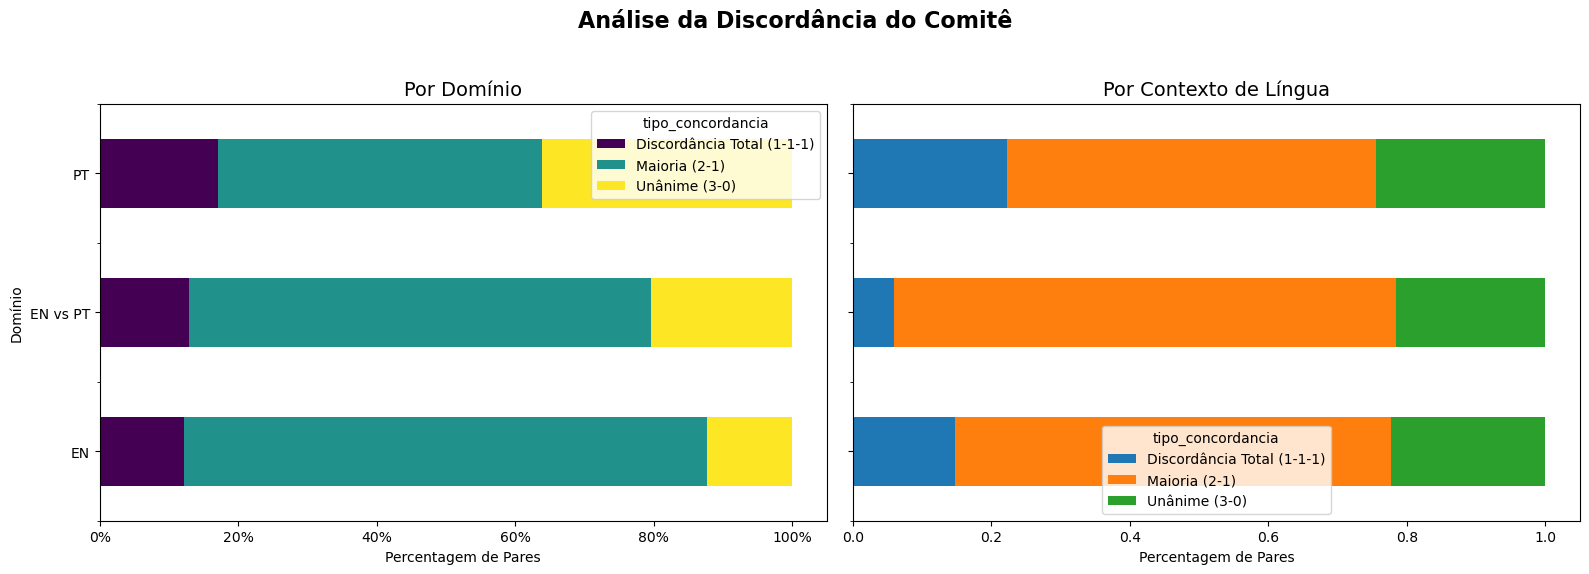

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
fig.suptitle('Análise da Discordância do Comitê', fontsize=16, weight='bold')

# Gráfico por Domínio
consenso_por_dominio.plot(kind='barh', stacked=True, ax=axes[0], colormap='viridis')
axes[0].set_title('Por Domínio', fontsize=14)
axes[0].set_xlabel('Percentagem de Pares')
axes[0].set_ylabel('Domínio')
axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))

# Gráfico por Língua
consenso_por_lingua.plot(kind='barh', stacked=True, ax=axes[1])
axes[1].set_title('Por Contexto de Língua', fontsize=14)
axes[1].set_xlabel('Percentagem de Pares')
axes[1].set_ylabel('')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [51]:
print("\n" + "="*50)
print("ANÁLISE DE CONCORDÂNCIA (JUIZ vs. HUMANOS)")
print("="*50)

# --- Acurácia Pareada ---
print("\n--- Acurácia Pareada ---")
for judge in ['claude', 'prometheus', 'mistral']:
    coluna_juiz = f'{judge}_winner'
    if coluna_juiz in df_validacao.columns:
        accuracy = accuracy_score(df_validacao['human_winner'], df_validacao[coluna_juiz])
        print(f"  - Acurácia do {judge.title()}: {accuracy:.2%}")
    else:
        print(f"  - AVISO: Coluna '{coluna_juiz}' não encontrada.")

# --- Kendall's Tau ---
print("\n--- Kendall's Tau (Correlação de Ranking) ---")
mapping = {'A': 1, 'B': -1, 'Tie': 0, 'Empate': 0}
df_validacao['human_choice_numeric'] = df_validacao['human_winner'].map(mapping)

for judge in ['claude', 'prometheus', 'mistral']:
    coluna_juiz = f'{judge}_winner'
    if coluna_juiz in df_validacao.columns:
        judge_choice_numeric = df_validacao[coluna_juiz].map(mapping)
        tau, p_value = kendalltau(df_validacao['human_choice_numeric'], judge_choice_numeric.fillna(0))
        print(f"  - Kendall's Tau do {judge.title()}: {tau:.4f} (p-value: {p_value:.3g})")
    else:
        print(f"  - AVISO: Coluna '{coluna_juiz}' não encontrada para o Kendall's Tau.")
    
print("\nEsta análise valida a fiabilidade dos juízes-LLM antes de os usarmos na análise principal.")


ANÁLISE DE CONCORDÂNCIA (JUIZ vs. HUMANOS)

--- Acurácia Pareada ---
  - Acurácia do Claude: 48.00%
  - Acurácia do Prometheus: 33.33%
  - Acurácia do Mistral: 40.00%

--- Kendall's Tau (Correlação de Ranking) ---
  - Kendall's Tau do Claude: 0.2171 (p-value: 0.00373)
  - Kendall's Tau do Prometheus: 0.1800 (p-value: 0.0166)
  - Kendall's Tau do Mistral: 0.0970 (p-value: 0.2)

Esta análise valida a fiabilidade dos juízes-LLM antes de os usarmos na análise principal.


* **Acurácia Baixa** (Todos abaixo de 50%): Significa que os juízes-LLM, na maioria das vezes, não escolheram o mesmo vencedor que a maioria dos humanos. O Claude foi o melhor, mas ainda assim só concordou 48% das vezes.

    Isto valida a nossa descoberta anterior sobre o baixo Fleiss' Kappa humano. Se os próprios humanos tiveram dificuldade em concordar entre si, é perfeitamente natural que um LLM também não consiga "adivinhar" a preferência de um grupo dividido.

**Kendall's Tau:**

* **Claude e Prometheus** (p-value < 0.05): A fraca concordância deles com os humanos é estatisticamente real. Não foi por acaso. Eles têm um sinal, ainda que fraco, de que pensam de forma alinhada com os humanos.

* **Mixtral** (p-value > 0.05): A concordância dele foi tão baixa que é indistinguível do acaso. Não podemos confiar que ele tenha qualquer alinhamento com a preferência humana.

In [52]:
df_validacao.to_csv('../../data/analysis/validated_analysis.csv', index=False, encoding='utf-8-sig')

In [53]:
df_master = pd.read_csv(FICHEIRO_MASTER)
df_master.head(2)

,evaluation_id,question_id,sample_n,domain,language,model,comparison,response_A,prompt_level_of_A,response_B,prompt_level_of_B,prompt_level,model_of_A,model_of_B,source_of_A,source_of_B,original_pt_response
0,CG013_2_General Knowledge_gemini-1.5-pro-lates...,CG013,2,General Knowledge,pt,gemini-1.5-pro-latest,minimum_vs_detailed,A fotossíntese é o processo pelo qual as plant...,detailed,Fotossíntese é o processo pelo qual organismos...,minimum,NaN,NaN,NaN,NaN,NaN,NaN
1,CR010_5_Creative_gpt-4o_minimum_vs_contextual_pt,CR010,5,Creative,pt,gpt-4o,minimum_vs_contextual,"Perder a capacidade de ver a cor vermelha, uma...",minimum,Esse é um tema fascinante e pode render um con...,contextual,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
df_final = pd.merge(
    df_analise,
    df_master,
    on='evaluation_id',
    how='left',
    suffixes=('', '_drop')
)

df_final = df_final[[col for col in df_final.columns if not col.endswith('_drop')]]

print("\nFicheiros juntados com sucesso.")
df_final.shape



Ficheiros juntados com sucesso.


(1500, 29)

In [55]:
df_final.head(2)

,evaluation_id,response_A,response_B,evaluation_claude,evaluation_prometheus,evaluation_mistral,claude_winner,claude_total_score,mistral_winner,mistral_total_score,...,model,comparison,prompt_level_of_A,prompt_level_of_B,prompt_level,model_of_A,model_of_B,source_of_A,source_of_B,original_pt_response
0,TC014_gemini-1.5-pro-latest_1_Technical_contex...,The primary use of a NumPy array is to efficie...,Numple matrices are the central data structure...,"{\n ""winner"": ""A"",\n ""general_justificat...","{\n ""winner"": ""A"",\n ""general_ju...","{\n ""winner"": ""A"",\n ""general_j...",A,5.0,A,5.00,...,gemini-1.5-pro-latest,NaN,NaN,NaN,contextual,NaN,NaN,english_original,portuguese_pivoted,As matrizes NumPy são a estrutura de dados cen...
1,CG004_gemini-1.5-pro-latest_4_General Knowledg...,The Proclamation of the Republic in Brazil on ...,"The proclamation of the Republic in Brazil, on...","{\n ""winner"": ""A"",\n ""general_justificat...","{\n""winner"": ""Tie"",\n""general_justification"": ...","{\n ""winner"": ""A"",\n ""general_justification...",A,5.0,A,4.75,...,gemini-1.5-pro-latest,NaN,NaN,NaN,minimum,NaN,NaN,english_original,portuguese_pivoted,"A Proclamação da República no Brasil, em 15 de..."


In [56]:
df_final.to_csv('../../data/analysis/complete_analysis.csv', index=False, encoding='utf-8-sig')